
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [2]:
## library imports here
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.model_selection import GridSearchCV, cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

In [1]:
ha.head()

NameError: name 'ha' is not defined

## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [112]:
X = ha.drop("cp", axis=1)
y = ha["cp"]

## KNN

In [113]:
# Define ColumnTransformer for preprocessing
ct = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'trtbps', 'chol', 'thalach'])  # Standardize numeric features
    ],
    remainder='passthrough'
)

# Define Pipeline with KNN
pipeline_knn = Pipeline(steps=[
    ('preprocessor', ct),
    ('classifier', KNeighborsClassifier())  # KNN model placeholder
])

# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9],    # K values for KNN
    'classifier__weights': ['uniform', 'distance'],  # Weighting schemes
    'classifier__p': [1, 2]  # Distance metric: Manhattan (p=1), Euclidean (p=2)
}

# Use StratifiedKFold for cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(
    pipeline_knn, 
    param_grid, 
    cv=stratified_cv, 
    scoring='accuracy',  # Adjust metric as needed
    n_jobs=-1  # Use all processors
)

# Fit GridSearchCV
grid_search.fit(X, y)

# Print best parameters
print("Best Parameters:", grid_search.best_params_)

# Use cross_val_predict with the best model from GridSearchCV
best_model = grid_search.best_estimator_
y_pred_cv = cross_val_predict(best_model, X, y, cv=stratified_cv)

# Generate classification report
print("Classification Report from Cross-Validation:\n")
print(classification_report(y, y_pred_cv))

Best Parameters: {'classifier__n_neighbors': 7, 'classifier__p': 2, 'classifier__weights': 'distance'}
Classification Report from Cross-Validation:

              precision    recall  f1-score   support

           0       0.68      0.80      0.73       128
           1       0.25      0.16      0.19        44
           2       0.41      0.44      0.43        81
           3       0.17      0.05      0.08        20

    accuracy                           0.53       273
   macro avg       0.38      0.36      0.36       273
weighted avg       0.49      0.53      0.51       273



## Decision Tree Classifier

In [114]:
# Define Pipeline for Decision Tree
pipeline_dt = Pipeline(steps=[
    ('preprocessor', ct),  # Use the same ColumnTransformer
    ('classifier', DecisionTreeClassifier(random_state=42))  # Decision Tree model placeholder
])

# Define parameter grid for GridSearchCV
param_grid_dt = {
    'classifier__max_depth': [3, 5, 10, None],       # Tree depth
    'classifier__min_samples_split': [2, 5, 10],    # Minimum samples for a split
    'classifier__min_samples_leaf': [1, 2, 4]       # Minimum samples per leaf
}

# GridSearchCV to find the best Decision Tree parameters
grid_search_dt = GridSearchCV(
    pipeline_dt,
    param_grid_dt,
    cv=stratified_cv,  # Use StratifiedKFold
    scoring='accuracy',
    n_jobs=-1
)

# Fit GridSearchCV
grid_search_dt.fit(X, y)

# Print best parameters
print("Best Parameters for Decision Tree:", grid_search_dt.best_params_)

# Use cross_val_predict with the best Decision Tree model
best_model_dt = grid_search_dt.best_estimator_
y_pred_cv_dt = cross_val_predict(best_model_dt, X, y, cv=stratified_cv)

# Generate classification report
print("Classification Report for Decision Tree from Cross-Validation:\n")
print(classification_report(y, y_pred_cv_dt))

Best Parameters for Decision Tree: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Classification Report for Decision Tree from Cross-Validation:

              precision    recall  f1-score   support

           0       0.66      0.71      0.68       128
           1       0.35      0.39      0.37        44
           2       0.45      0.46      0.45        81
           3       0.00      0.00      0.00        20

    accuracy                           0.53       273
   macro avg       0.37      0.39      0.38       273
weighted avg       0.50      0.53      0.52       273



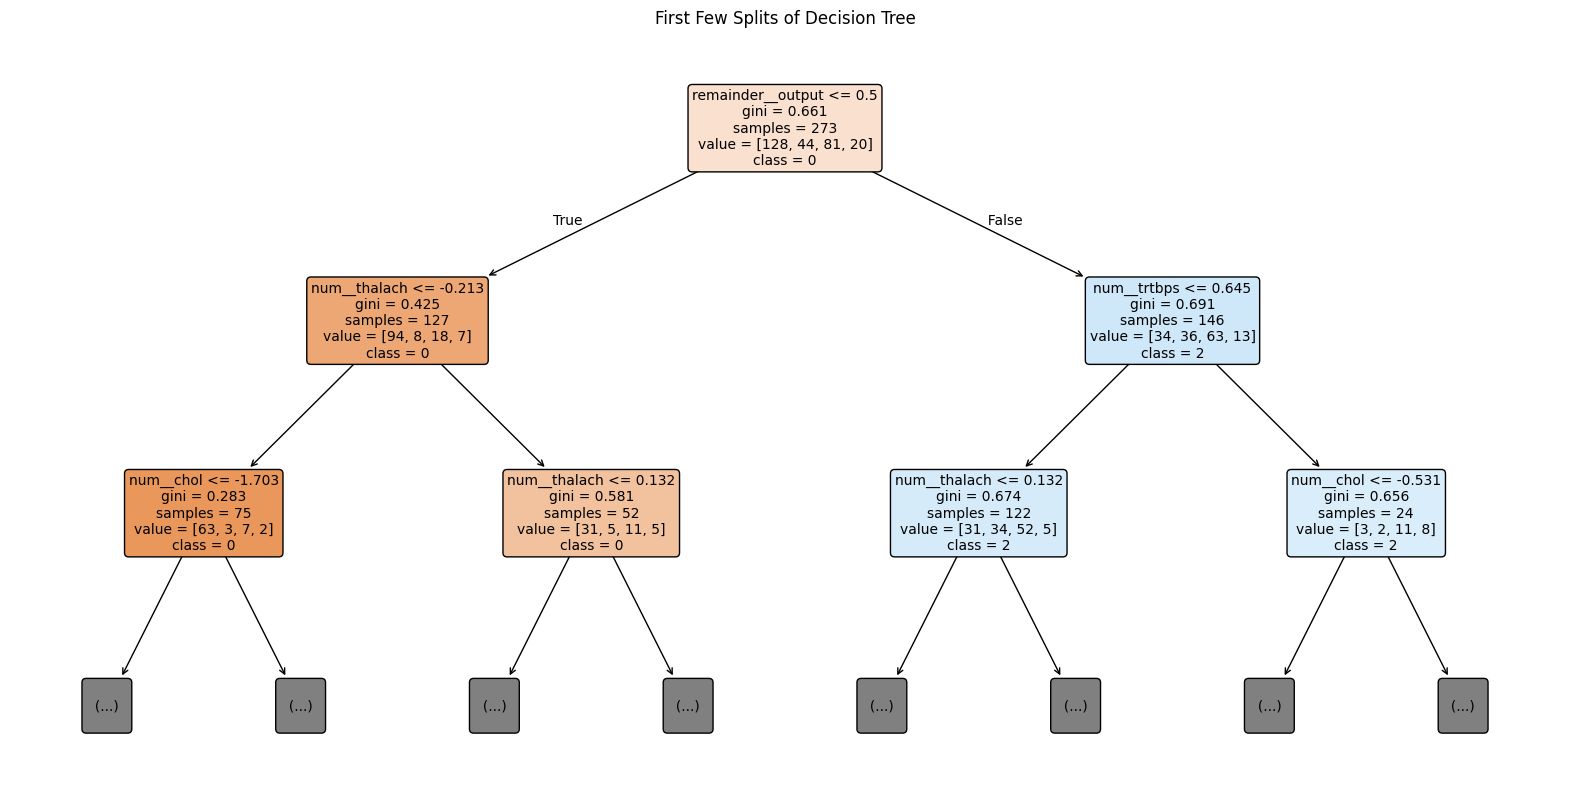

In [115]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Access the DecisionTreeClassifier from the pipeline
best_tree = grid_search_dt.best_estimator_.named_steps['classifier']

# Fit the ColumnTransformer to get feature names
grid_search_dt.best_estimator_.named_steps['preprocessor'].fit(X)
feature_names = grid_search_dt.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

# Plot the first few splits of the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(
    best_tree, 
    feature_names=feature_names,  # Correctly extract feature names
    class_names=["0", "1", "2", "3"],  # Replace with your class labels
    max_depth=2,  # Plot only the first few levels of the tree
    filled=True, 
    rounded=True
)
plt.title("First Few Splits of Decision Tree")
plt.show()

At the root node, the tree evaluates the feature `remainder_output` with a threshold of 0.5. This split divides the dataset into two groups: patients with `remainder_output <= 0.5`, which predominantly belong to chest pain class 0 (angina-related pain), and those with `remainder_output > 0.5`, where the distribution is more mixed but leans toward class 2.

For the group where `remainder_output <= 0.5`, the next split uses `num_thalach` (a scaled version of maximum heart rate achieved) with a threshold of -0.213. This further separates patients into those more likely to have chest pain class 0 (angina) versus a smaller mix of other classes. The Gini impurity decreases, reflecting a clearer distinction between the classes. Conversely, for the group where `remainder_output > 0.5`, the model splits on `num_trtbps` (a scaled version of resting blood pressure) with a threshold of 0.645. This split narrows the focus toward classifying between class 2 and the remaining categories, though the impurity remains relatively high due to the mixed class distribution in this group.

Overall, these early splits indicate that `remainder_output` serves as a key differentiator, likely capturing a broad categorization of patient conditions. Subsequent splits refine predictions by incorporating heart rate (`num_thalach`) and blood pressure (`num_trtbps`), which are critical physiological indicators linked to chest pain symptoms. These decisions align with medical intuition, as heart rate and blood pressure are known predictors of cardiovascular stress and related conditions.

## LDA

In [116]:
# Define Pipeline for LDA
pipeline_lda = Pipeline(steps=[
    ('preprocessor', ct),  # Use the same ColumnTransformer
    ('classifier', LinearDiscriminantAnalysis())  # LDA model
])

# Define parameter grid for GridSearchCV
param_grid_lda = {
    'classifier__solver': ['svd', 'lsqr', 'eigen'],  # Solver for LDA
    'classifier__shrinkage': [None, 'auto', 0.1, 0.5]  # Shrinkage for 'lsqr' or 'eigen'
}

# GridSearchCV to find the best LDA parameters
grid_search_lda = GridSearchCV(
    pipeline_lda,
    param_grid_lda,
    cv=stratified_cv,  # Use StratifiedKFold
    scoring='accuracy',
    n_jobs=-1
)

# Fit GridSearchCV
grid_search_lda.fit(X, y)

# Print best parameters
print("Best Parameters for LDA:", grid_search_lda.best_params_)

# Use cross_val_predict with the best LDA model
best_model_lda = grid_search_lda.best_estimator_
y_pred_cv_lda = cross_val_predict(best_model_lda, X, y, cv=stratified_cv)

# Generate classification report
print("Classification Report for LDA from Cross-Validation:\n")
print(classification_report(y, y_pred_cv_lda))

Best Parameters for LDA: {'classifier__shrinkage': None, 'classifier__solver': 'svd'}
Classification Report for LDA from Cross-Validation:

              precision    recall  f1-score   support

           0       0.73      0.76      0.75       128
           1       0.10      0.02      0.04        44
           2       0.42      0.67      0.51        81
           3       0.50      0.05      0.09        20

    accuracy                           0.56       273
   macro avg       0.44      0.37      0.35       273
weighted avg       0.52      0.56      0.52       273



C:\Users\isabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\isabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\isabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\isabe\AppDat

## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing? 

In [117]:
# Create a new column `cp_is_3`
ha_copy = ha.copy()
ha_copy["cp_is_3"] = (ha_copy["cp"] == 3).astype(int)

# Logistic Regression Pipeline
pipeline_lr = Pipeline(steps=[
    ('preprocessor', ct),  # Use the same ColumnTransformer
    ('classifier', LogisticRegression(random_state=42, class_weight="balanced"))  # Logistic Regression
])

# Fit the model and calculate F1 Score for `cp_is_3`
X = ha_copy.drop(["cp_is_3", "cp"], axis=1)
y = ha_copy["cp_is_3"]

# StratifiedKFold for consistent splits
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validate predictions
y_pred_cv_lr = cross_val_predict(pipeline_lr, X, y, cv=stratified_cv)

print("Classification Report for cp_is_3:\n")
print(classification_report(y, y_pred_cv_lr, target_names=["Not Class 3", "Class 3"]))

Classification Report for cp_is_3:

              precision    recall  f1-score   support

 Not Class 3       0.95      0.70      0.80       253
     Class 3       0.12      0.50      0.19        20

    accuracy                           0.68       273
   macro avg       0.53      0.60      0.50       273
weighted avg       0.89      0.68      0.76       273



In [118]:
# OvR for all cp categories
f1_scores = {}

for cp_class in range(4):
    target_col = f"cp_is_{cp_class}"
    ha_copy[target_col] = (ha_copy["cp"] == cp_class).astype(int)
    
    y = ha_copy[target_col]
    y_pred_cv_lr = cross_val_predict(pipeline_lr, X, y, cv=stratified_cv)
    
    report = classification_report(y, y_pred_cv_lr, output_dict=True)
    f1_scores[target_col] = report["1"]["f1-score"]

    print(f"Classification Report for {target_col}:\n")
    print(classification_report(y, y_pred_cv_lr, target_names=[f"Not Class {cp_class}", f"Class {cp_class}"]))
    print("\n")

# Determine the category with the highest F1 Score
best_category = max(f1_scores, key=f1_scores.get)
print(f"Best OvR category: {best_category} w/ an F1 Score of {f1_scores[best_category]:}.")

Classification Report for cp_is_0:

              precision    recall  f1-score   support

 Not Class 0       0.78      0.74      0.76       145
     Class 0       0.72      0.76      0.74       128

    accuracy                           0.75       273
   macro avg       0.75      0.75      0.75       273
weighted avg       0.75      0.75      0.75       273



Classification Report for cp_is_1:

              precision    recall  f1-score   support

 Not Class 1       0.92      0.63      0.75       229
     Class 1       0.27      0.73      0.40        44

    accuracy                           0.64       273
   macro avg       0.60      0.68      0.57       273
weighted avg       0.82      0.64      0.69       273



Classification Report for cp_is_2:

              precision    recall  f1-score   support

 Not Class 2       0.85      0.58      0.69       192
     Class 2       0.43      0.75      0.55        81

    accuracy                           0.63       273
   macro avg    

The results indicate that the model performs best in distinguishing patients with **asymptomatic chest pain (Class 0)**, achieving an F1 score of 0.74. With a precision of 0.72 and recall of 0.76, the model effectively balances minimizing false positives and identifying true positives for this category. This consistent performance makes `Class 0` the best distinguished category by the OvR approach.

For **typical angina (Class 1)**, the model struggles significantly, with a low precision of 0.27 but a recall of 0.73. This high recall suggests the model captures most true positives, but the large number of false positives drags down the precision and the F1 score to 0.40. The imbalanced nature of the dataset, with only 44 samples for `Class 1`, likely contributes to the poor performance. Oversampling or class weighting could help address this issue.

In the case of **atypical angina (Class 2)**, the model achieves a slightly better precision of 0.43 and a recall of 0.75, resulting in an F1 score of 0.55. While this is an improvement over `Class 1`, the model still struggles due to the moderate class imbalance, with only 81 samples belonging to `Class 2`. The weighted average indicates a bias toward predicting `Not Class 2`, which is consistent with the class imbalance.

The model performs worst for **non-anginal pain (Class 3)**, achieving a precision of only 0.12 and an F1 score of 0.19. Although the recall is 0.50, the high false positive rate significantly reduces the model’s overall performance. The small sample size of only 20 cases for `Class 3` makes it challenging for the model to generalize, highlighting the need for the balancing techniques done like the class weighting as done when calling the Logistic Regression

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [119]:
# Dict to store ROC-AUC scores
roc_auc_scores = {}

# OvO comparisons for cp = 0 vs 1, 0 vs 2, and 0 vs 3
for cp_class in range(1, 4):  # Compare cp = 0 with cp = 1, 2, 3
    # Filter dataset for the two classes (0 and cp_class)
    ha_ovo = ha[ha["cp"].isin([0, cp_class])].copy()
    
    # Define features and target
    X = ha_ovo.drop(columns=["cp"])  # Features (drop the cp column)
    y = (ha_ovo["cp"] == cp_class).astype(int)  # Binary target: 0 for cp = 0, 1 for cp = cp_class
    
    # Cross-validate predictions with probabilities
    y_pred_probs = cross_val_predict(pipeline_lr, X, y, cv=stratified_cv, method="predict_proba")[:, 1]
    
    # Calculate ROC-AUC
    roc_auc = roc_auc_score(y, y_pred_probs)
    roc_auc_scores[f"0_vs_{cp_class}"] = roc_auc
    
    print(f"ROC-AUC for 0 vs {cp_class}: {roc_auc:.4f}")

# Determine the pair with the highest ROC-AUC
best_pair = max(roc_auc_scores, key=roc_auc_scores.get)
print(f"\nBest OvO pair: {best_pair} w/ ROC-AUC of {roc_auc_scores[best_pair]:.4f}.")

ROC-AUC for 0 vs 1: 0.8185
ROC-AUC for 0 vs 2: 0.7351
ROC-AUC for 0 vs 3: 0.7086

Best OvO pair: 0_vs_1 w/ ROC-AUC of 0.8185.


 The results indicate that the OvO approach is most effective at distinguishing between `Class 0` (asymptomatic pain) and `Class 1` (typical angina), achieving an ROC-AUC of **0.8185**. This score suggests that the logistic regression model can reliably separate these two classes, likely due to distinct patterns in the dataset, such as differences in resting blood pressure or maximum heart rate. The clear distinction between these groups makes this pair the best distinguished by the OvO approach.

In comparison, the model performs moderately well at distinguishing `Class 0` from `Class 2` (atypical angina), with an ROC-AUC of **0.7351**. This lower score suggests greater overlap in patient characteristics between these two categories, making them harder to separate. The distinction becomes even more challenging for `Class 0` and `Class 3` (non-anginal pain), which achieve the lowest ROC-AUC of **0.7086**. The reduced performance in this pair may be due to similarities in physiological indicators or a smaller sample size for `Class 3`, which could limit the model’s ability to learn meaningful differences.